In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# we don't want to see warnings
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data.csv')
df.columns = [col.strip() for col in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
url                              39644 non-null object
timedelta                        39644 non-null float64
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
n_unique_tokens                  39644 non-null float64
n_non_stop_words                 39644 non-null float64
n_non_stop_unique_tokens         39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null floa

In [2]:
# let's create a function that will perform linear and ridge regression, 
# use GridSearchCV to find optimal hyperparameters and print median_absolute_error
def perform_linear_and_ridge_regression(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42) 
    
    lin_reg_parameters = {
        'fit_intercept': [True, False]
    }
    lin_reg = GridSearchCV(LinearRegression(), lin_reg_parameters, cv=5)
    lin_reg.fit(X=X_train, y=Y_train)
    Y_pred = lin_reg.predict(X_test)
    print('Linear regression MAE =', median_absolute_error(Y_test, Y_pred))
    
    rid_reg_parameters = {
        'alpha': np.arange(0.5, 5, 0.5),
        'fit_intercept': [True, False],
        #'max_iter' : range(500, 1500, 500), this doesn't seem to have any effect
        #'solver' : ['auto', 'svd', 'saga'] this one takes waaay too long for some reason
    }
    rid_reg = GridSearchCV(Ridge(), rid_reg_parameters, cv=5)
    rid_reg.fit(X=X_train, y=Y_train)
    Y_pred = rid_reg.predict(X_test)
    print('Ridge regression MAE =', median_absolute_error(Y_test, Y_pred))

In [3]:
# remove non-predictive features first
df.drop(columns=['url', 'timedelta'], inplace=True)
# and let's make our first attempt
perform_linear_and_ridge_regression(X=df.drop(columns=['shares']), Y=df['shares'])
# as suggested in the assignment the first attempt results in MAE around 1700

Linear regression MAE = 1690.9906911462958
Ridge regression MAE = 1687.703286686748


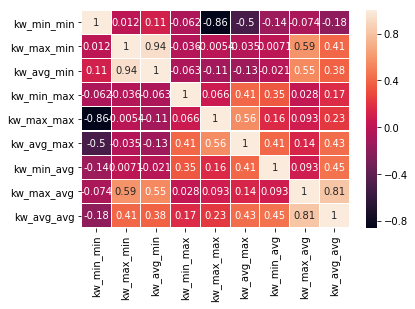

In [4]:
# before we drop some of the columns with low correlation let's look at the kw features
# we don't get too much information about the kw features
# are worst keywords the ones least relevant to the topic or are they mostly in the least shared articles?
# looking at the data it's probably the second but we can't tell for sure 
# let's look at the correlation matrix of kw features and shares feature
sns.heatmap(df[[column for column in df.columns if 'kw_' in column]].corr(), linewidths=0.1, annot=True)

In [5]:
# as expected, those columns are pretty correlated, let's try removing all the _min and _max features
# so we only keep the kw_avg features (and kw_avg_max because of it's high correlation with shares)
df_test = df.drop(columns=['kw_min_min', 'kw_max_min', 'kw_min_max', 'kw_max_max', 'kw_avg_min'])
# let's see whether it had a possitive effect
perform_linear_and_ridge_regression(X=df_test.drop(columns=['shares']), Y=df_test['shares'])
# very small improvement, but we take it
df = df_test

Linear regression MAE = 1688.4487370781935
Ridge regression MAE = 1687.3015135167698


In [6]:
# let's see the correlation of all the predicting features with shares feature
display(df.corr()['shares'].head(53))
# describe correlation values in abs with 5%, 8%, 10% and 20% percentiles
df_corr = pd.DataFrame(df.corr()['shares'].head(53).abs())
display(df_corr.describe(percentiles=[0.05, 0.08, 0.1, 0.2]))

n_tokens_title                   0.008783
n_tokens_content                 0.002459
n_unique_tokens                  0.000806
n_non_stop_words                 0.000443
n_non_stop_unique_tokens         0.000114
num_hrefs                        0.045404
num_self_hrefs                  -0.001900
num_imgs                         0.039388
num_videos                       0.023936
average_token_length            -0.022007
num_keywords                     0.021818
data_channel_is_lifestyle        0.005831
data_channel_is_entertainment   -0.017006
data_channel_is_bus             -0.012376
data_channel_is_socmed           0.005021
data_channel_is_tech            -0.013253
data_channel_is_world           -0.049497
kw_avg_max                       0.044686
kw_min_avg                       0.039551
kw_max_avg                       0.064306
kw_avg_avg                       0.110413
self_reference_min_shares        0.055958
self_reference_max_shares        0.047115
self_reference_avg_sharess       0

,shares
count,53.000000
mean,0.021801
std,0.023278
min,0.000040
5%,0.000503
8%,0.000914
10%,0.001565
20%,0.003996
50%,0.013241
max,0.110413


In [7]:
# find features with correlation in the bottom 5%
df_corr.loc[df_corr['shares'] < 0.000503]

,shares
n_non_stop_words,0.000443
n_non_stop_unique_tokens,0.000114
min_positive_polarity,0.000040


In [8]:
# drop the features
df_test = df.drop(columns=['min_positive_polarity', 'n_non_stop_words', 'n_non_stop_unique_tokens'])
# let's see whether it had a possitive effect
perform_linear_and_ridge_regression(X=df_test.drop(columns=['shares']), Y=df_test['shares'])
# we got a little bit worse results for the Linear regression but better results for Ridge regression
df = df_test

Linear regression MAE = 1689.4863366649952
Ridge regression MAE = 1680.0201746394828


In [9]:
# the possitive effect of removing low correlated features means we will try this again
# find features with correlation in the bottom 8%
df_corr.loc[df_corr['shares'] < 0.000914]

,shares
n_unique_tokens,0.000806
n_non_stop_words,0.000443
n_non_stop_unique_tokens,0.000114
global_rate_positive_words,0.000543
min_positive_polarity,0.000040


In [10]:
# drop the features
df_test = df.drop(columns=['n_unique_tokens', 'global_rate_positive_words'])
# let's see whether it had a possitive effect
perform_linear_and_ridge_regression(X=df_test.drop(columns=['shares']), Y=df_test['shares'])
# better results for the Linear regression this time
df = df_test

Linear regression MAE = 1675.6158601174375
Ridge regression MAE = 1680.0683331177215


In [11]:
# the is_weekend feature is probably not needed (because of the weekday_is_saturday and weekday_is_sunday features)
# let's try removing it and look at the results
df_test = df.drop(columns=['is_weekend'])
perform_linear_and_ridge_regression(X=df_test.drop(columns=['shares']), Y=df_test['shares'])
# the result is almost the same, just a very tiny bit better

Linear regression MAE = 1675.615860014992
Ridge regression MAE = 1679.9322763796786


In [12]:
# now let's try removing the weekday_is_saturday and weekday_is_sunday features and keep the is_weekend
df_test = df.drop(columns=['weekday_is_saturday', 'weekday_is_sunday'])
perform_linear_and_ridge_regression(X=df_test.drop(columns=['shares']), Y=df_test['shares'])
# this gives us better results than removing is_weekend
df = df_test

Linear regression MAE = 1672.4176806939968
Ridge regression MAE = 1673.9185805535199


In [13]:
# I've randomly tried removing the LDA columns and it provided the biggest improvement so far
LDA_columns = ['LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04']
df_test = df.drop(columns=LDA_columns)
perform_linear_and_ridge_regression(X=df_test.drop(columns=['shares']), Y=df_test['shares'])
df = df_test

Linear regression MAE = 1661.6030491897732
Ridge regression MAE = 1665.4172699027085


In [14]:
# let's see the average number of shares for each weekday
display(df[['weekday_is_monday', 'shares']].groupby('weekday_is_monday').agg('mean'))
display(df[['weekday_is_tuesday', 'shares']].groupby('weekday_is_tuesday').agg('mean'))
display(df[['weekday_is_wednesday', 'shares']].groupby('weekday_is_wednesday').agg('mean'))
display(df[['weekday_is_thursday', 'shares']].groupby('weekday_is_thursday').agg('mean'))
display(df[['weekday_is_friday', 'shares']].groupby('weekday_is_friday').agg('mean'))

,shares
weekday_is_monday,
0.0,3344.559713
1.0,3647.025822


,shares
weekday_is_tuesday,
0.0,3439.572518
1.0,3202.500677


,shares
weekday_is_wednesday,
0.0,3416.611289
1.0,3303.405380


,shares
weekday_is_thursday,
0.0,3444.036569
1.0,3178.599147


,shares
weekday_is_friday,
0.0,3413.889020
1.0,3285.181021


In [15]:
# we can see that wednesday and friday are very simillar just like tuestday and thursday
# let's try merging them into pairs - create is_tuesday_or_thursday and is_wednesday_or_friday

def is_tuesday_or_thursday(row):
    if row['weekday_is_tuesday'] == 1:
        return 1
    if row['weekday_is_thursday'] == 1:
        return 1
    return 0

def is_wednesday_or_friday(row):
    if row['weekday_is_wednesday'] == 1:
        return 1
    if row['weekday_is_friday'] == 1:
        return 1
    return 0

df_test['is_tuesday_or_thursday'] = df_test.apply(lambda row: is_tuesday_or_thursday(row), axis=1)
df_test['is_wednesday_or_friday'] = df_test.apply(lambda row: is_wednesday_or_friday(row), axis=1)
# remove all the weekday_is features
df_test = df_test.drop(columns=['weekday_is_monday', 'weekday_is_tuesday','weekday_is_wednesday','weekday_is_thursday','weekday_is_friday'])
perform_linear_and_ridge_regression(X=df_test.drop(columns=['shares']), Y=df_test['shares'])
# the improvement is only 0.4 for Ridge regression, but we still got rid of 5 features for 2
df = df_test

Linear regression MAE = 1661.0423731135497
Ridge regression MAE = 1664.4858315780402


In [16]:
# let's see the average number of shares for each data channel category
display(df[['data_channel_is_lifestyle', 'shares']].groupby('data_channel_is_lifestyle').agg('mean'))
display(df[['data_channel_is_entertainment', 'shares']].groupby('data_channel_is_entertainment').agg('mean'))
display(df[['data_channel_is_bus', 'shares']].groupby('data_channel_is_bus').agg('mean'))
display(df[['data_channel_is_socmed', 'shares']].groupby('data_channel_is_socmed').agg('mean'))
display(df[['data_channel_is_tech', 'shares']].groupby('data_channel_is_tech').agg('mean'))
display(df[['data_channel_is_world', 'shares']].groupby('data_channel_is_world').agg('mean'))

,shares
data_channel_is_lifestyle,
0.0,3379.349447
1.0,3682.123392


,shares
data_channel_is_entertainment,
0.0,3487.394513
1.0,2970.487034


,shares
data_channel_is_bus,
0.0,3457.679327
1.0,3063.018536


,shares
data_channel_is_socmed,
0.0,3380.814957
1.0,3629.383125


,shares
data_channel_is_tech,
0.0,3468.866772
1.0,3072.283283


,shares
data_channel_is_world,
0.0,3694.388218
1.0,2287.734069


In [17]:
# I've tried merging tech with bus and socmed with lifestyle features, but it didn't improve the results

# let's add feature that represents number of categories of each article
def n_categories(row):
    return row['data_channel_is_lifestyle'] + row['data_channel_is_entertainment'] + row['data_channel_is_bus'] + row['data_channel_is_socmed'] + row['data_channel_is_tech'] + row['data_channel_is_world']
    
df_test['n_categories'] = df_test.apply(lambda row: n_categories(row), axis=1)
perform_linear_and_ridge_regression(X=df_test.drop(columns=['shares']), Y=df_test['shares'])
# Ridge reg got improved a little bit
df = df_test

Linear regression MAE = 1661.0423732548907
Ridge regression MAE = 1663.591049883973


In [18]:
# when I was trying to do somethingh wih positive and negative word rates, 
# I've discovered that removing rate_negative_words feature improves the scores
df_test = df_test.drop(columns=['rate_negative_words'])
perform_linear_and_ridge_regression(X=df_test.drop(columns=['shares']), Y=df_test['shares'])
df = df_test

Linear regression MAE = 1657.9722452866868
Ridge regression MAE = 1662.5118814524285


In [19]:
# title_subjectivity and abs_title_subjectivity sounds like too similar features 
# removing the title_subjectivity feature gives us better results
df_test = df_test.drop(columns=['title_subjectivity'])
perform_linear_and_ridge_regression(X=df_test.drop(columns=['shares']), Y=df_test['shares'])
df = df_test

Linear regression MAE = 1654.2217858224021
Ridge regression MAE = 1660.4798032861795


In [20]:
# I don't have any idea what to do with the features next, so these are the final features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 38 columns):
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null float64
data_channel_is_socmed           39644 non-null float64
data_channel_is_tech             39644 non-null float64
data_channel_is_world            39644 non-null float64
kw_avg_max                       39644 non-null float64
kw_min_avg                       39644 non-null flo

In [21]:
# let's do some normalization, standardization and other transformations now 
# there are a buch of binary features (weekday_is_monday, data_channel_is_lifestyle etc.)
# we must keep in mind that transforming those wouldn't be a good idea
binary_columns = ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 
                   'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 
                  'is_tuesday_or_thursday', 'is_wednesday_or_friday', 'is_weekend', 'n_categories']

# other than that, there are bunch of features that seem scaled already (rate_positive_words etc.)

# I've tried not scaling each of these columns, but it had a negative effect on the scores
subjectivity_columns = ['global_subjectivity', 'abs_title_subjectivity']
rate_columns = ['rate_positive_words', 'global_rate_negative_words']
polarity_columns = ['avg_positive_polarity', 'max_positive_polarity', 'avg_negative_polarity', 
                 'min_negative_polarity', 'max_negative_polarity', 'title_sentiment_polarity', 
                    'global_sentiment_polarity', 'abs_title_sentiment_polarity']

lowstd_columns=['n_tokens_title', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
        'num_keywords', 'n_tokens_content']
dontscale_columns = binary_columns + subjectivity_columns + rate_columns + polarity_columns + lowstd_columns

# describe the remaining features
df.drop(columns=binary_columns+subjectivity_columns+rate_columns+polarity_columns).describe(include='all')

,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,10.883690,3.293638,4.544143,1.249874,4.548239,7.223767,259281.938083,1117.146610,5657.211151,3135.858639,3998.755396,10329.212662,6401.697580,3395.380184
std,2.114037,471.107508,11.332017,3.855141,8.309434,4.107855,0.844406,1.909130,135102.247285,1137.456951,6098.871957,1318.150397,19738.670516,41027.576613,24211.332231,11626.950749
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,9.000000,246.000000,4.000000,1.000000,1.000000,0.000000,4.478404,6.000000,172846.875000,0.000000,3562.101631,2382.448566,639.000000,1100.000000,981.187500,946.000000
50%,10.000000,409.000000,8.000000,3.000000,1.000000,0.000000,4.664082,7.000000,244572.222223,1023.635611,4355.688836,2870.074878,1200.000000,2800.000000,2200.000000,1400.000000
75%,12.000000,716.000000,14.000000,4.000000,4.000000,1.000000,4.854839,9.000000,330980.000000,2056.781032,6019.953968,3600.229564,2600.000000,8000.000000,5200.000000,2800.000000
max,23.000000,8474.000000,304.000000,116.000000,128.000000,91.000000,8.041534,10.000000,843300.000000,3613.039820,298400.000000,43567.659946,843300.000000,843300.000000,843300.000000,843300.000000


In [22]:
# I've tried using these transformators with these results:
# sklearn.preprocessing.Normalizer
# Linear regression MAE = 1750.7696860719507
# Ridge regression MAE = 1754.4521590251807

# sklearn.preprocessing.StandardScaler
# Linear regression MAE = 1657.1384740860321
# Ridge regression MAE = 1657.7284066638595

# sklearn.preprocessing.PowerTransformer
# Linear regression MAE = 1723.1408321137283
# Ridge regression MAE = 1723.0101042191618

# sklearn.preprocessing.RobustScaler
# Linear regression MAE = 1657.7723885145679
# Ridge regression MAE = 1657.658674200049

# sklearn.preprocessing.QuantileTransformer
# Linear regression MAE = 1739.5108472224529
# Ridge regression MAE = 1745.7884436520026

# sklearn.preprocessing.MaxAbsScaler
# Linear regression MAE = 1654.2217858023487
# Ridge regression MAE = 1662.4768169350627

# sklearn.preprocessing.MinMaxScaler
# Linear regression MAE = 1672.8884740860321
#Ridge regression MAE = 1662.5198158173225

# the results are shockingly bad as none of the transformers gave us better results for both models
# I might have done something wrong here, but I've used it the same way in the 3rd homework

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=['shares'])
# separate binary and non binary features
X_binary = X[binary_columns]
X = X.drop(columns=binary_columns)
Y = df['shares']
transformer = MaxAbsScaler().fit(X)
X_scaled = transformer.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# stitch binary and scaled non binary features back together
X = pd.merge(X_scaled, X_binary, left_index=True, right_index=True)
perform_linear_and_ridge_regression(X=X, Y=Y)

Linear regression MAE = 1654.2217858023487
Ridge regression MAE = 1662.4768169350627


In [24]:
# dimension reduction doesn't help us much, the best n_components=36 so we lose just one dimension
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=36, n_iter=10, random_state=42)
X = pca.fit_transform(df.drop(columns=['shares']))
Y = df['shares']
perform_linear_and_ridge_regression(X=X, Y=Y)

Linear regression MAE = 1654.2217858022977
Ridge regression MAE = 1660.4798032861795


In [25]:
# changing the problem from regression to classification might help here, 
# but since this assignment is about regression so we won't dig into that

# so after many painfull hours of trying we've improved the scores by roughly 3% :'(
# let's try running some different models though

In [26]:
# let's try logistic regression first
from sklearn.linear_model import LogisticRegression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42) 
    
parameters = {
    'multi_class': ['multinomial'],
    'n_jobs': [4],
    'tol': [0.1],
    'solver' : ['sag']
}
# I didn't use GridSearchCV here because it just took way too long
log_reg = LogisticRegression(multi_class='multinomial', tol=0.1, solver='sag')
log_reg.fit(X=X_train, y=Y_train)
Y_pred = log_reg.predict(X_test)
print('Logistic regression MAE =', median_absolute_error(Y_test, Y_pred))
# MAE = 500 WOW! After x hours of working with the features all that was needed was to use a different model

Logistic regression MAE = 500.0


In [31]:
# let's try AdaBoostRegressor now
from sklearn.ensemble import AdaBoostRegressor

parameters = {
    'n_estimators': range(10, 50, 5),
    'learning_rate': range(1, 2)
}

ab = GridSearchCV(AdaBoostRegressor(), parameters, cv=5)
ab.fit(X=X_train, y=Y_train)
Y_pred = ab.predict(X_test)
print('AdaBoost MAE =', median_absolute_error(Y_test, Y_pred))
# terrible result

AdaBoost MAE = 5715.498245614035


In [35]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# I didn't go through many hyperparameter combinations because it took too long
parameters = {
    'n_estimators': range(10, 50, 20),
    'max_depth': range(4, 5),
    'n_jobs': [4]
}
rf = GridSearchCV(RandomForestRegressor(), parameters, cv=5)
rf.fit(X=X_train, y=Y_train)
Y_pred = rf.predict(X_test)
print('AdaBoost MAE =', median_absolute_error(Y_test, Y_pred))
# results are similar to the Linear regression

AdaBoost MAE = 1694.4332293223547


In [40]:
# LinearSVR
from sklearn.svm import LinearSVR

parameters = {
    'epsilon': [0.0, 0.1],
    'C': [1.0, 2.0],
    'fit_intercept': [True]
}
lsvr = GridSearchCV(LinearSVR(), parameters, cv=5)
lsvr.fit(X=X_train, y=Y_train)
Y_pred = lsvr.predict(X_test)
print('LinearSRV MAE =', median_absolute_error(Y_test, Y_pred))
# pretty good result, but still no way near the Logistic regression

LinearSRV MAE = 1040.3775526638942


In [41]:
# in the end we got to MAE = 500.0 using Logistic regression
# we might have done even better if I had more time and computing power on my side to test more hyperparameters